In [18]:
# Imports and styling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

plt.style.use('default')

In [19]:
# Initial dataset handling
"""
survival 	Survival 	            0 = No, 1 = Yes
pclass 	    Ticket class 	        1 = 1st, 2 = 2nd, 3 = 3rd
sex 	    Sex 	
Age 	    Age in years 	
sibsp 	    # of siblings / spouses aboard the Titanic 	
parch 	    # of parents / children aboard the Titanic 	
ticket 	    Ticket number 	
fare 	    Passenger fare 	
cabin 	    Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
"""
df_train = pd.read_csv('input/train.csv', sep=',')
df_test = pd.read_csv('input/test.csv', sep=',')
ids_test = df_test["PassengerId"]

# Remove unusuable string parameters, plus cabin has many NaN values
df_train = df_train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
df_test = df_test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# Map strings to numeric values
df_train["Sex"] = df_train["Sex"].map({"male": 0, "female": 1})
df_train["Embarked"] = df_train["Embarked"].map({"C": 0, "Q": 1, "S": 2})
df_test["Sex"] = df_test["Sex"].map({"male": 0, "female": 1})
df_test["Embarked"] = df_test["Embarked"].map({"C": 0, "Q": 1, "S": 2})

In [20]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [21]:
df_test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [22]:
# Fill in missing fare value
df_test["Fare"] = df_test["Fare"].replace(np.NaN, df_test["Fare"].mean())

# Fill in missing age values considering SibSp and Parch
age_cols = ["SibSp", "Parch", "Age"]
impute = IterativeImputer()

X_age = df_train[age_cols]
df_age = pd.DataFrame(np.round(impute.fit_transform(X_age)), columns=age_cols)
df_train["Age"] = df_age["Age"]

X_age = df_test[age_cols]
df_age = pd.DataFrame(np.round(impute.fit_transform(X_age)), columns=age_cols)
df_test["Age"] = df_age["Age"]

# Remove rows with negative ages
df_train["Age"] = df_train[df_train["Age"] >= 0]["Age"]

# Remove rows with empty embarked values from the training data
df_train = df_train.dropna().reset_index(drop=True)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


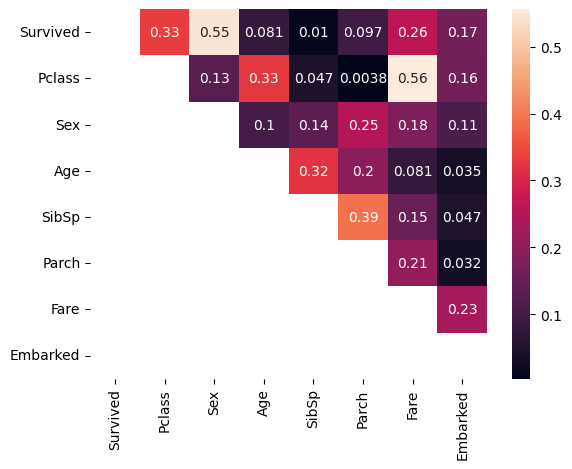

Age      0.080560
SibSp    0.010423
Parch    0.097486
Name: Survived, dtype: float64

In [23]:
# Correlation matrix to check for unusable values
corr_matrix = df_train.corr()
upper_tri = abs(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
plt.figure()
sns.heatmap(upper_tri, annot=True)
plt.show()

cor_target = abs(corr_matrix["Survived"])
to_drop = cor_target[cor_target < 0.1]
to_drop

<AxesSubplot:ylabel='Frequency'>

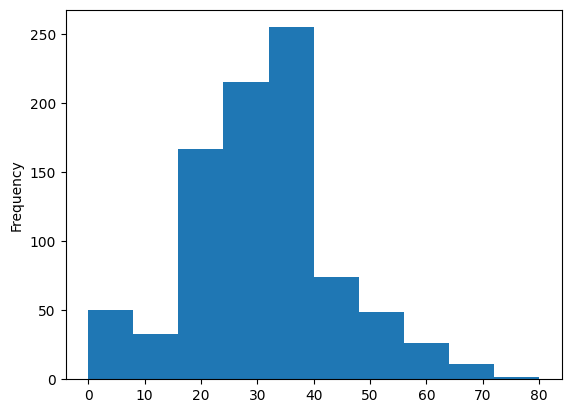

In [24]:
df_train["Age"].plot(kind='hist')

In [25]:
bins = [-0.1, 9, 15, 24, 59, 80]
group_names = [0, 1, 2, 3, 4]

"""
child -  0 to  9 years
teen  - 10 to 15 years
young - 15 to 24 years
adult - 25 to 59 years
elder - 59 to 80 years
"""

df_train["Age"] = pd.to_numeric(pd.cut(df_train["Age"], bins, labels=group_names))

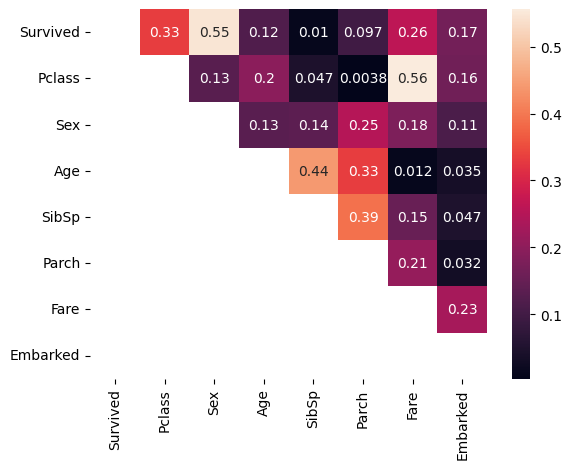

SibSp    0.010423
Parch    0.097486
Name: Survived, dtype: float64

In [26]:
# Correlation matrix to check for unusable values
corr_matrix = df_train.corr()
upper_tri = abs(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
plt.figure()
sns.heatmap(upper_tri, annot=True)
plt.show()

cor_target = abs(corr_matrix["Survived"])
to_drop = cor_target[cor_target < 0.1]
to_drop

In [27]:
# SibSp, Parch and Age have low correlation with the output parameter, so they're also removed
df_train = df_train.drop(["SibSp", "Parch"], axis=1)
df_test = df_test.drop(["SibSp", "Parch"], axis=1)

In [28]:
X_train = df_train.drop(["Survived"], axis=1)
y_train = df_train["Survived"]

In [29]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[2,3,4,5], 'max_features':['sqrt', 'log2'], 'max_leaf_nodes':[4,8,16,32]}
dt2 = DecisionTreeClassifier()
clf = GridSearchCV(dt2, parameters, return_train_score=True)
clf.fit(X_train, y_train)
results = pd.DataFrame(clf.cv_results_)
results.nsmallest(5, "rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
30,0.001465,0.000050,0.001025,0.000064,gini,5,log2,16,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.813559,...,0.814092,0.018418,1,0.829787,0.825532,0.779037,0.810198,0.813031,0.811517,0.017828
63,0.001851,0.000474,0.001156,0.000212,entropy,5,log2,32,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.790960,...,0.807293,0.021190,2,0.842553,0.838298,0.805949,0.837110,0.815864,0.827955,0.014383
27,0.001515,0.000062,0.001124,0.000161,gini,5,sqrt,32,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.802260,...,0.805001,0.031774,3,0.828369,0.843972,0.844193,0.838527,0.750708,0.821154,0.035687
54,0.002095,0.000488,0.001337,0.000196,entropy,4,log2,16,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.774011,...,0.802741,0.025558,4,0.809929,0.785816,0.801700,0.817280,0.821530,0.807251,0.012664
14,0.001760,0.000539,0.001122,0.000168,gini,3,log2,16,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.768362,...,0.801637,0.025211,5,0.787234,0.792908,0.821530,0.831445,0.815864,0.809796,0.016955


In [30]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(df_test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(max_depth=depth)
    for train_fold, valid_fold in cv.split(df_train):
        f_train = df_train.loc[train_fold]
        f_valid = df_train.loc[valid_fold]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(f_valid.drop(["Survived"], axis=1), f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy) / len(fold_accuracy)
    accuracies.append(avg)

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.787921
         2          0.794791
         3          0.820838
         4          0.835598
         5          0.848072


In [31]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
 
training_score = dt.score(X_train, y_train)
print("Training set score: {:.4f}".format(training_score))

Training set score: 0.9297


In [32]:
prediction = dt.predict(df_test)

In [33]:
output = pd.DataFrame({"PassengerId" : ids_test, "Survived": prediction})
output.to_csv("submission.csv", index=False)

[Text(0.4833324535472973, 0.975, 'X[1] <= 0.5\ngini = 0.474\nsamples = 882\nvalue = [542, 340]'),
 Text(0.18984902871621623, 0.925, 'X[2] <= 0.5\ngini = 0.308\nsamples = 573\nvalue = [464, 109]'),
 Text(0.013513513513513514, 0.875, 'X[0] <= 2.5\ngini = 0.482\nsamples = 32\nvalue = [13, 19]'),
 Text(0.006756756756756757, 0.825, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]'),
 Text(0.02027027027027027, 0.825, 'X[3] <= 20.825\ngini = 0.472\nsamples = 21\nvalue = [13, 8]'),
 Text(0.013513513513513514, 0.775, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(0.02702702702702703, 0.775, 'X[3] <= 31.331\ngini = 0.133\nsamples = 14\nvalue = [13, 1]'),
 Text(0.02027027027027027, 0.725, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.033783783783783786, 0.725, 'X[3] <= 35.538\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.02702702702702703, 0.675, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.04054054054054054, 0.675, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.36618454391

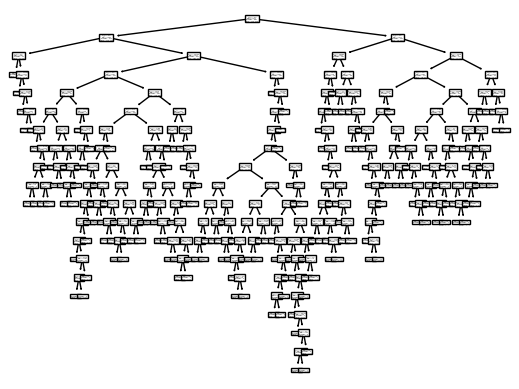

In [34]:
plot_tree(dt)